# Fake News Text Generator
I dette projekt er gruppen blevet hyret til at få produceret fake news til danske medier, får at skabe ravage i det danske samfund. Projektet vil bestå af en Model der vil generere tekst ud fra en start sætning. Tekst generering er svært at få en maskine til at forstå, da tekst har kontekst bagved(en sætning af ord af bogstaver). 

## Dette er filen hvor vi har fundet den bedste model - med det bedste output (tekst sætnings kontekst)
Kig i Final-Model-text-gen.ipynb for at se det færdige produkt



## 1. Import af biblioteker



In [50]:
# keras module for building LSTM 
import tensorflow as tf
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, GRUV2, Bidirectional, SimpleRNN
from keras_preprocessing.text import Tokenizer
from keras.models import Sequential
import keras.utils as ku 

# set seeds for reproducability

from numpy.random import seed

seed(1)

import pandas as pd
import numpy as np
import string, os 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

## 2. Indlæs dataset

In [51]:

df = pd.read_csv('./data/Fake.csv')
df2 = pd.read_csv('./data/True.csv')
df.append(df2)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


# Data Preprocessing

In [52]:
df = df.drop(['title','subject','date'], axis=1)
df = df.dropna(subset=['text'])
len(df.values)
print(df.isna())
print(df.values[:5])

        text
0      False
1      False
2      False
3      False
4      False
...      ...
23476  False
23477  False
23478  False
23479  False
23480  False

[23481 rows x 1 columns]
[['Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s twee

## Dataset preparation 

In [53]:
def clean_text(txt):
    txt = "".join(v for v in txt if v not in string.punctuation).lower()
    txt = txt.encode("utf8").decode("ascii",'ignore')
    return txt 

corpus = [clean_text(x) for x in df.values]
corpus = corpus[:10]
corpus[:5]


['donald trump just couldn t wish all americans a happy new year and leave it at that. instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  the former reality show star had just one job to do and he couldn t do it. as our country rapidly grows stronger and smarter, i want to wish all of my friends, supporters, enemies, haters, and even the very dishonest fake news media, a happy and healthy new year,  president angry pants tweeted.  2018 will be a great year for america! as our country rapidly grows stronger and smarter, i want to wish all of my friends, supporters, enemies, haters, and even the very dishonest fake news media, a happy and healthy new year. 2018 will be a great year for america!  donald j. trump (@realdonaldtrump) december 31, 2017trump s tweet went down about as welll as you d expect.what kind of president sends a new year s greeting like this despicable, petty, infantile gibberish? only trump! his lack of decency won t e

In [54]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences_train, total_words_train = get_sequence_of_tokens(corpus)


print("train tokenized output:",inp_sequences_train[:10])
#pretty tabel visualized
inp_sequences_train[:10]

train tokenized output: [[38, 6], [38, 6, 39], [38, 6, 39, 307], [38, 6, 39, 307, 18], [38, 6, 39, 307, 18, 119], [38, 6, 39, 307, 18, 119, 31], [38, 6, 39, 307, 18, 119, 31, 147], [38, 6, 39, 307, 18, 119, 31, 147, 4], [38, 6, 39, 307, 18, 119, 31, 147, 4, 101], [38, 6, 39, 307, 18, 119, 31, 147, 4, 101, 42]]


[[38, 6],
 [38, 6, 39],
 [38, 6, 39, 307],
 [38, 6, 39, 307, 18],
 [38, 6, 39, 307, 18, 119],
 [38, 6, 39, 307, 18, 119, 31],
 [38, 6, 39, 307, 18, 119, 31, 147],
 [38, 6, 39, 307, 18, 119, 31, 147, 4],
 [38, 6, 39, 307, 18, 119, 31, 147, 4, 101],
 [38, 6, 39, 307, 18, 119, 31, 147, 4, 101, 42]]

In [55]:
#Padding is a special form of masking where the masked steps are at the start or the end of a sequence. 
#Padding comes from the need to encode sequence data into contiguous batches: in order to make all sequences in a batch fit a given standard length,
# it is necessary to pad or truncate some sequences
def generate_padded_sequences(input_sequences,total_words):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len



#### padded sekvens data


In [56]:
#predictors er X og labels er Y.
predictors_train, label_train, max_sequence_len_train = generate_padded_sequences(inp_sequences_train,total_words_train)


print(predictors_train.shape)

print(label_train.shape)
predictors_train[:10]


(4148, 610)
(4148, 1370)


array([[  0,   0,   0, ...,   0,   0,  38],
       [  0,   0,   0, ...,   0,  38,   6],
       [  0,   0,   0, ...,  38,   6,  39],
       ...,
       [  0,   0,   0, ..., 119,  31, 147],
       [  0,   0,   0, ...,  31, 147,   4],
       [  0,   0,   0, ..., 147,   4, 101]])

# Model RNN med Bidirectional LSTM

In [57]:
from tensorflow import keras
def create_model(max_sequence_len, total_words, lr, hidden,dropout):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    model.add(Embedding(total_words, 20, input_length=input_len))
    

    model.add(Bidirectional(LSTM(hidden)))
    model.add(Dropout(dropout))
    
    model.add(Dense(total_words, activation='softmax')) 

    model.compile(
     optimizer=keras.optimizers.Adam(learning_rate=lr),  
    loss="categorical_crossentropy", 
    metrics=[keras.metrics.CategoricalAccuracy(), 
    keras.metrics.MeanAbsoluteError()], 
    )
    
    return model



In [58]:
model = create_model(max_sequence_len_train, total_words_train,lr=0.001,hidden=100,dropout=0.15)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 610, 20)           27400     
                                                                 
 bidirectional_3 (Bidirectio  (None, 200)              96800     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 1370)              275370    
                                                                 
Total params: 399,570
Trainable params: 399,570
Non-trainable params: 0
_________________________________________________________________


# Test af Bidirectional LSTM

In [59]:
epochs = 30
history =model.fit(predictors_train, label_train, epochs=epochs, verbose=1)

Epoch 1/30
130/130 [==============================] - 40s 288ms/step - loss: 6.7151 - categorical_accuracy: 0.0427 - mean_absolute_error: 0.0015
Epoch 2/30
130/130 [==============================] - 39s 300ms/step - loss: 6.3525 - categorical_accuracy: 0.0456 - mean_absolute_error: 0.0015
Epoch 3/30
130/130 [==============================] - 38s 293ms/step - loss: 6.2839 - categorical_accuracy: 0.0456 - mean_absolute_error: 0.0014
Epoch 4/30
130/130 [==============================] - 38s 296ms/step - loss: 6.1958 - categorical_accuracy: 0.0456 - mean_absolute_error: 0.0014
Epoch 5/30
130/130 [==============================] - 39s 298ms/step - loss: 6.0658 - categorical_accuracy: 0.0506 - mean_absolute_error: 0.0014
Epoch 6/30
130/130 [==============================] - 40s 310ms/step - loss: 5.8663 - categorical_accuracy: 0.0571 - mean_absolute_error: 0.0014
Epoch 7/30
130/130 [==============================] - 38s 289ms/step - loss: 5.6420 - categorical_accuracy: 0.0673 - mean_absolute

### Evaluating af modellen

In [60]:
print("Evaluate history from training")
print(history.history)

Evaluate history from training
{'loss': [6.7150983810424805, 6.352531909942627, 6.2839274406433105, 6.195846080780029, 6.06580114364624, 5.866263389587402, 5.641965389251709, 5.422946929931641, 5.212406635284424, 5.008119583129883, 4.828906059265137, 4.642673969268799, 4.486734867095947, 4.324116230010986, 4.167413234710693, 4.02599573135376, 3.87807559967041, 3.7437896728515625, 3.59822154045105, 3.477870225906372, 3.3591654300689697, 3.2269561290740967, 3.1103591918945312, 3.00553560256958, 2.8865034580230713, 2.7827672958374023, 2.6983137130737305, 2.5796704292297363, 2.498325824737549, 2.401869773864746], 'categorical_accuracy': [0.042671166360378265, 0.04556412622332573, 0.04556412622332573, 0.04556412622332573, 0.050626806914806366, 0.057135969400405884, 0.06726133078336716, 0.07377049326896667, 0.08365477621555328, 0.09932497888803482, 0.10173577815294266, 0.11909353733062744, 0.12560270726680756, 0.14440694451332092, 0.16345226764678955, 0.17526519298553467, 0.20515911281108856

[6.71509838 6.35253191 6.28392744 6.19584608 6.06580114 5.86626339
 5.64196539 5.42294693 5.21240664 5.00811958 4.82890606 4.64267397
 4.48673487 4.32411623 4.16741323 4.02599573 3.8780756  3.74378967
 3.59822154 3.47787023 3.35916543 3.22695613 3.11035919 3.0055356
 2.88650346 2.7827673  2.69831371 2.57967043 2.49832582 2.40186977]


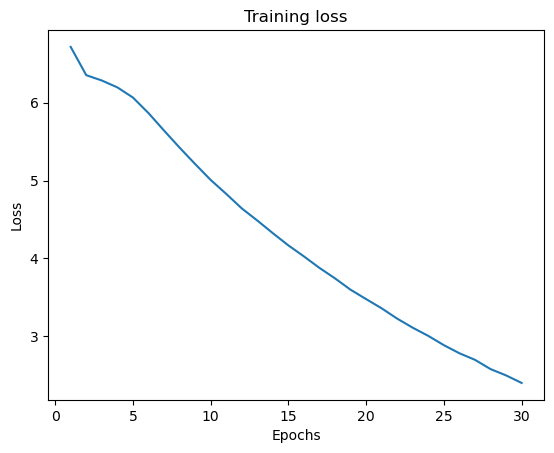

In [61]:
loss_train =  np.array(history.history['loss'])
epochs = range(1,epochs+1)
print(loss_train)
plt.plot(epochs,loss_train)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

range(1, 31)
[0.04267117 0.04556413 0.04556413 0.04556413 0.05062681 0.05713597
 0.06726133 0.07377049 0.08365478 0.09932498 0.10173578 0.11909354
 0.12560271 0.14440694 0.16345227 0.17526519 0.20515911 0.22709739
 0.25458053 0.28399229 0.31677917 0.34715524 0.37343299 0.39971071
 0.42622951 0.4481678  0.45853424 0.49734813 0.50385725 0.53447443]


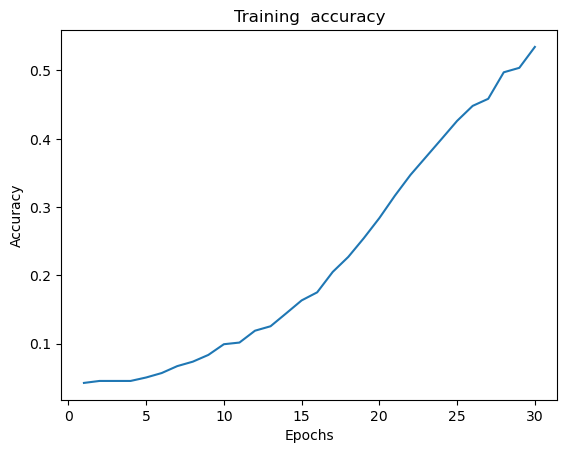

In [62]:
acc_train = np.array(history.history['categorical_accuracy'])
print(epochs)
print(acc_train)
plt.plot(epochs,acc_train)
plt.title('Training  accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Generator for tekst


In [63]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_x=model.predict(token_list) 
        predicted=np.argmax(predicted_x,axis=1)
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

### Generate text

In [64]:
print (generate_text("united states is a", 20, model, max_sequence_len_train))


1/1 [==============================] - 0s 48ms/step
United States Is A Happy David Nunes And Going To Wish In The Capital Of The Sharp New And Bitch Slap These Scum Bags


# Test af LSTM model

In [65]:
from tensorflow import keras
def create_model(max_sequence_len, total_words, lr, hidden,dropout):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    model.add(Embedding(total_words, 20, input_length=input_len))
    model.add(LSTM(hidden)) 
    model.add(Dropout(dropout)) 
    
    model.add(Dense(total_words, activation='softmax')) 

    model.compile(
     optimizer=keras.optimizers.Adam(learning_rate=lr),  
    loss="categorical_crossentropy", 
    metrics=[keras.metrics.CategoricalAccuracy(), 
    keras.metrics.MeanAbsoluteError()], 
    )
    
    return model



In [66]:
model = create_model(max_sequence_len_train, total_words_train,lr=0.001,hidden=100,dropout=0.15)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 610, 20)           27400     
                                                                 
 lstm_7 (LSTM)               (None, 100)               48400     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 1370)              138370    
                                                                 
Total params: 214,170
Trainable params: 214,170
Non-trainable params: 0
_________________________________________________________________


In [67]:
epochs = 30
history =model.fit(predictors_train, label_train, epochs=epochs, verbose=1)

Epoch 1/30
130/130 [==============================] - 25s 178ms/step - loss: 6.7250 - categorical_accuracy: 0.0398 - mean_absolute_error: 0.0015
Epoch 2/30
130/130 [==============================] - 22s 170ms/step - loss: 6.3360 - categorical_accuracy: 0.0453 - mean_absolute_error: 0.0015
Epoch 3/30
130/130 [==============================] - 22s 167ms/step - loss: 6.2228 - categorical_accuracy: 0.0456 - mean_absolute_error: 0.0014
Epoch 4/30
130/130 [==============================] - 23s 176ms/step - loss: 6.1386 - categorical_accuracy: 0.0456 - mean_absolute_error: 0.0014
Epoch 5/30
130/130 [==============================] - 22s 172ms/step - loss: 6.0626 - categorical_accuracy: 0.0468 - mean_absolute_error: 0.0014
Epoch 6/30
130/130 [==============================] - 22s 166ms/step - loss: 5.9813 - categorical_accuracy: 0.0535 - mean_absolute_error: 0.0014
Epoch 7/30
130/130 [==============================] - 21s 165ms/step - loss: 5.8886 - categorical_accuracy: 0.0574 - mean_absolute

### Evaluering af LSTM

In [68]:
print("Evaluate history from training")
print(history.history)

Evaluate history from training
{'loss': [6.724961280822754, 6.336031913757324, 6.222825050354004, 6.1385979652404785, 6.062617778778076, 5.981308460235596, 5.888615608215332, 5.7996039390563965, 5.706779479980469, 5.6154584884643555, 5.529959678649902, 5.449370861053467, 5.368370532989502, 5.28516149520874, 5.20009708404541, 5.116250991821289, 5.037232398986816, 4.953534126281738, 4.877420902252197, 4.785951137542725, 4.707757949829102, 4.617719650268555, 4.532083988189697, 4.448627471923828, 4.3593974113464355, 4.268616199493408, 4.18419075012207, 4.095146179199219, 4.009868621826172, 3.926668882369995], 'categorical_accuracy': [0.0397782064974308, 0.045323047786951065, 0.04556412622332573, 0.04556412622332573, 0.04676952585577965, 0.05351976677775383, 0.05737704783678055, 0.06002892926335335, 0.06147541105747223, 0.057859208434820175, 0.06726133078336716, 0.07063645124435425, 0.07786884903907776, 0.07883317023515701, 0.08365477621555328, 0.08944069594144821, 0.09570877254009247, 0.09

[6.72496128 6.33603191 6.22282505 6.13859797 6.06261778 5.98130846
 5.88861561 5.79960394 5.70677948 5.61545849 5.52995968 5.44937086
 5.36837053 5.2851615  5.20009708 5.11625099 5.0372324  4.95353413
 4.8774209  4.78595114 4.70775795 4.61771965 4.53208399 4.44862747
 4.35939741 4.2686162  4.18419075 4.09514618 4.00986862 3.92666888]


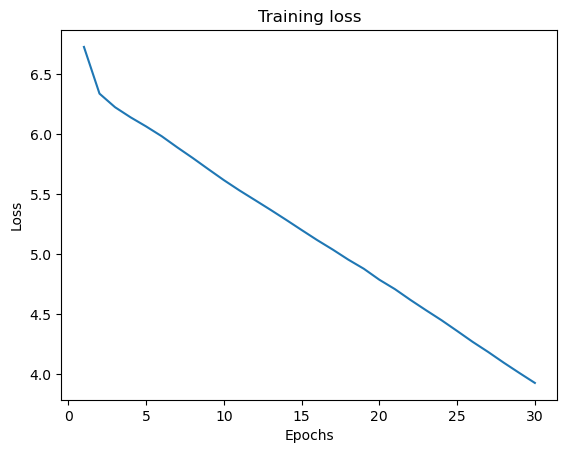

In [69]:
loss_train =  np.array(history.history['loss'])
epochs = range(1,epochs+1)
print(loss_train)
plt.plot(epochs,loss_train)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

range(1, 31)
[0.03977821 0.04532305 0.04556413 0.04556413 0.04676953 0.05351977
 0.05737705 0.06002893 0.06147541 0.05785921 0.06726133 0.07063645
 0.07786885 0.07883317 0.08365478 0.0894407  0.09570877 0.09811958
 0.09691417 0.11041465 0.11065574 0.12343298 0.12921891 0.13741562
 0.14681774 0.15501447 0.17020251 0.17984571 0.19165863 0.19623916]


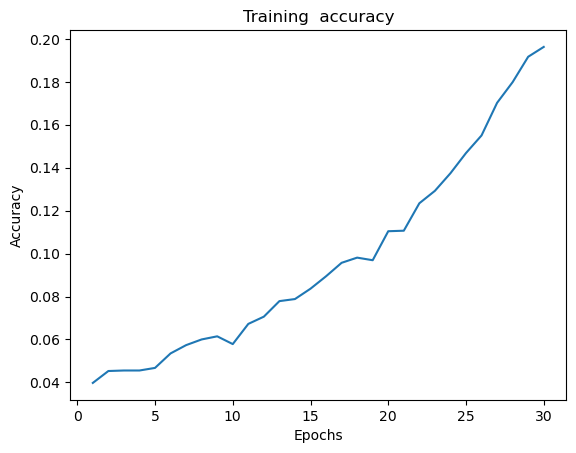

In [70]:
acc_train = np.array(history.history['categorical_accuracy'])
print(epochs)
print(acc_train)
plt.plot(epochs,acc_train)
plt.title('Training  accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Generate text

In [71]:
print (generate_text("united states is a", 20, model, max_sequence_len_train))

1/1 [==============================] - 0s 38ms/step
United States Is A Great In The New In The New In The New York Times And The Report Jr Sheriffclarke December 30 2017You


# Test med GRU 

In [72]:
from tensorflow import keras
def create_model(max_sequence_len, total_words, lr, hidden,dropout):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    model.add(Embedding(total_words, 20, input_length=input_len))

    model.add(GRUV2(hidden)) 
    model.add(Dropout(dropout)) 
    
    model.add(Dense(total_words, activation='softmax')) 

    model.compile(
     optimizer=keras.optimizers.Adam(learning_rate=lr),  
    loss="categorical_crossentropy", 
    metrics=[keras.metrics.CategoricalAccuracy(), 
    keras.metrics.MeanAbsoluteError()], 
    )
    
    return model



In [73]:
model = create_model(max_sequence_len_train, total_words_train,lr=0.001,hidden=100,dropout=0.15)
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 610, 20)           27400     
                                                                 
 gru_1 (GRU)                 (None, 100)               36600     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 1370)              138370    
                                                                 
Total params: 202,370
Trainable params: 202,370
Non-trainable params: 0
_________________________________________________________________


In [74]:
epochs = 30
history =model.fit(predictors_train, label_train, epochs=epochs, verbose=1)

Epoch 1/30
130/130 [==============================] - 25s 177ms/step - loss: 6.7839 - categorical_accuracy: 0.0410 - mean_absolute_error: 0.0015
Epoch 2/30
130/130 [==============================] - 23s 175ms/step - loss: 6.3409 - categorical_accuracy: 0.0456 - mean_absolute_error: 0.0015
Epoch 3/30
130/130 [==============================] - 23s 176ms/step - loss: 6.2220 - categorical_accuracy: 0.0456 - mean_absolute_error: 0.0014
Epoch 4/30
130/130 [==============================] - 23s 174ms/step - loss: 6.0731 - categorical_accuracy: 0.0494 - mean_absolute_error: 0.0014
Epoch 5/30
130/130 [==============================] - 23s 176ms/step - loss: 5.8888 - categorical_accuracy: 0.0564 - mean_absolute_error: 0.0014
Epoch 6/30
130/130 [==============================] - 23s 175ms/step - loss: 5.6885 - categorical_accuracy: 0.0627 - mean_absolute_error: 0.0014
Epoch 7/30
130/130 [==============================] - 23s 176ms/step - loss: 5.4750 - categorical_accuracy: 0.0723 - mean_absolute

### Evaluering af GRU

In [75]:
print("Evaluate history from training")
print(history.history)

Evaluate history from training
{'loss': [6.78394079208374, 6.340883731842041, 6.2220072746276855, 6.07308292388916, 5.888828277587891, 5.6885175704956055, 5.4749860763549805, 5.259336471557617, 5.036663055419922, 4.825514793395996, 4.622551918029785, 4.4065656661987305, 4.201685905456543, 4.023036003112793, 3.831087827682495, 3.6587038040161133, 3.4767301082611084, 3.3189735412597656, 3.1530237197875977, 2.985602617263794, 2.8455538749694824, 2.720423460006714, 2.58109974861145, 2.442107677459717, 2.3157551288604736, 2.2166593074798584, 2.1125106811523438, 2.0171244144439697, 1.9075376987457275, 1.8281338214874268], 'categorical_accuracy': [0.04098360612988472, 0.04556412622332573, 0.04556412622332573, 0.04942140728235245, 0.05641273036599159, 0.06268081068992615, 0.07232401520013809, 0.08630665391683578, 0.09860173612833023, 0.11282546073198318, 0.1313886195421219, 0.1545322984457016, 0.16755062341690063, 0.18852458894252777, 0.21697203814983368, 0.24324975907802582, 0.276277720928192

[6.78394079 6.34088373 6.22200727 6.07308292 5.88882828 5.68851757
 5.47498608 5.25933647 5.03666306 4.82551479 4.62255192 4.40656567
 4.20168591 4.023036   3.83108783 3.6587038  3.47673011 3.31897354
 3.15302372 2.98560262 2.84555387 2.72042346 2.58109975 2.44210768
 2.31575513 2.21665931 2.11251068 2.01712441 1.9075377  1.82813382]


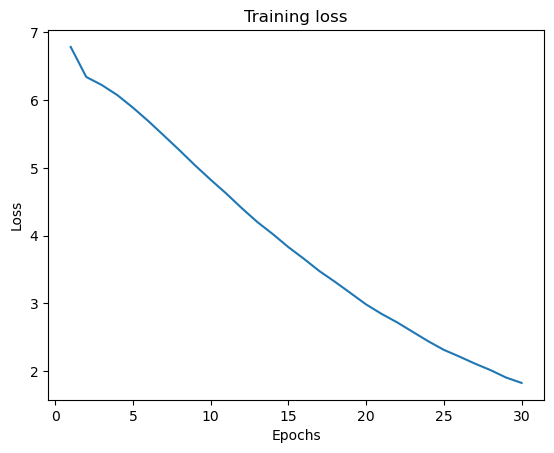

In [76]:
loss_train =  np.array(history.history['loss'])
epochs = range(1,epochs+1)
print(loss_train)
plt.plot(epochs,loss_train)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

range(1, 31)
[0.04098361 0.04556413 0.04556413 0.04942141 0.05641273 0.06268081
 0.07232402 0.08630665 0.09860174 0.11282546 0.13138862 0.1545323
 0.16755062 0.18852459 0.21697204 0.24324976 0.27627772 0.30761814
 0.34811959 0.38524589 0.42044359 0.44165862 0.47251686 0.49783027
 0.52772421 0.5419479  0.57377046 0.58678883 0.61764705 0.63162971]


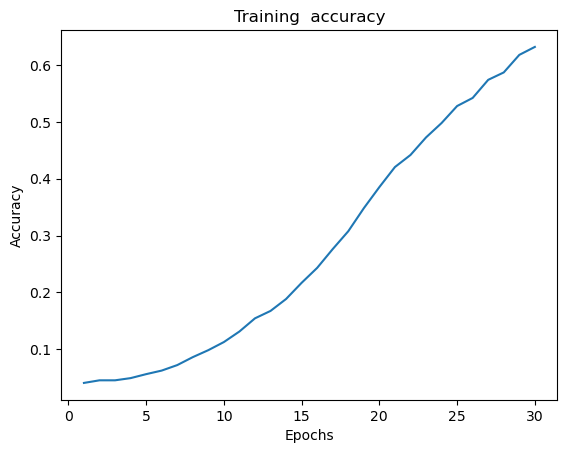

In [77]:
acc_train = np.array(history.history['categorical_accuracy'])
print(epochs)
print(acc_train)
plt.plot(epochs,acc_train)
plt.title('Training  accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Generate text

In [78]:
print (generate_text("united states is a", 20, model, max_sequence_len_train))

1/1 [==============================] - 0s 47ms/step
United States Is A Significant Distortion Of The Phony Hillary Clinton Investigation Including Her 33 000 Illegally Deleted Emails Be Given 700 000 For


# Test af Simple RNN 

In [79]:
from tensorflow import keras
def create_model(max_sequence_len, total_words, lr, hidden,dropout):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    model.add(Embedding(total_words, 20, input_length=input_len))

    model.add(SimpleRNN(hidden)) 
    model.add(Dropout(dropout))
    
    model.add(Dense(total_words, activation='softmax')) 

    model.compile(
     optimizer=keras.optimizers.Adam(learning_rate=lr),  
    loss="categorical_crossentropy", 
    metrics=[keras.metrics.CategoricalAccuracy(), 
    keras.metrics.MeanAbsoluteError()], 
    )
    
    return model



In [80]:
model = create_model(max_sequence_len_train, total_words_train,lr=0.001,hidden=100,dropout=0.15)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 610, 20)           27400     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               12100     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 1370)              138370    
                                                                 
Total params: 177,870
Trainable params: 177,870
Non-trainable params: 0
_________________________________________________________________


In [81]:
epochs = 30
history =model.fit(predictors_train, label_train, epochs=epochs, verbose=1)

Epoch 1/30
130/130 [==============================] - 11s 76ms/step - loss: 7.2255 - categorical_accuracy: 0.0046 - mean_absolute_error: 0.0015
Epoch 2/30
130/130 [==============================] - 10s 77ms/step - loss: 7.2110 - categorical_accuracy: 0.0046 - mean_absolute_error: 0.0015
Epoch 3/30
130/130 [==============================] - 10s 76ms/step - loss: 6.6727 - categorical_accuracy: 0.0289 - mean_absolute_error: 0.0015
Epoch 4/30
130/130 [==============================] - 10s 75ms/step - loss: 6.4084 - categorical_accuracy: 0.0436 - mean_absolute_error: 0.0015
Epoch 5/30
130/130 [==============================] - 11s 82ms/step - loss: 6.3924 - categorical_accuracy: 0.0456 - mean_absolute_error: 0.0015
Epoch 6/30
130/130 [==============================] - 10s 79ms/step - loss: 6.3698 - categorical_accuracy: 0.0456 - mean_absolute_error: 0.0014
Epoch 7/30
130/130 [==============================] - 10s 78ms/step - loss: 6.4321 - categorical_accuracy: 0.0432 - mean_absolute_error:

### Evaluering af Simple RNN

In [82]:
print("Evaluate history from training")
print(history.history)

Evaluate history from training
{'loss': [7.225532054901123, 7.2110466957092285, 6.672654628753662, 6.408360481262207, 6.392409324645996, 6.369805335998535, 6.432126045227051, 6.3910908699035645, 6.250805377960205, 6.151579856872559, 6.012653827667236, 5.940464496612549, 5.907500743865967, 6.290045261383057, 6.37227725982666, 5.971459865570068, 5.830699920654297, 5.787302017211914, 5.645655155181885, 5.637207984924316, 5.567838668823242, 5.467327117919922, 5.378244400024414, 5.291859149932861, 5.211670875549316, 5.130393028259277, 5.047152519226074, 4.9615068435668945, 4.8539228439331055, 4.773420333862305], 'categorical_accuracy': [0.004580520559102297, 0.004580520559102297, 0.028929604217410088, 0.04363548755645752, 0.04556412622332573, 0.04556412622332573, 0.04315332695841789, 0.043876565992832184, 0.04580520838499069, 0.05159112811088562, 0.05810029059648514, 0.06340405344963074, 0.06268081068992615, 0.054484087973833084, 0.050626806914806366, 0.06702025234699249, 0.0706364512443542

[7.22553205 7.2110467  6.67265463 6.40836048 6.39240932 6.36980534
 6.43212605 6.39109087 6.25080538 6.15157986 6.01265383 5.9404645
 5.90750074 6.29004526 6.37227726 5.97145987 5.83069992 5.78730202
 5.64565516 5.63720798 5.56783867 5.46732712 5.3782444  5.29185915
 5.21167088 5.13039303 5.04715252 4.96150684 4.85392284 4.77342033]


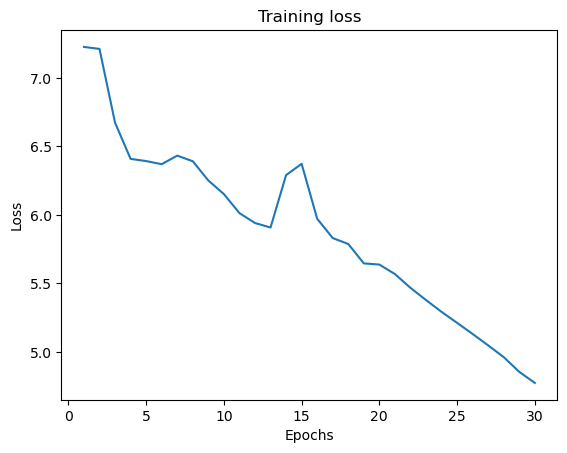

In [83]:
loss_train =  np.array(history.history['loss'])
epochs = range(1,epochs+1)
print(loss_train)
plt.plot(epochs,loss_train)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

range(1, 31)
[0.00458052 0.00458052 0.0289296  0.04363549 0.04556413 0.04556413
 0.04315333 0.04387657 0.04580521 0.05159113 0.05810029 0.06340405
 0.06268081 0.05448409 0.05062681 0.06702025 0.07063645 0.07063645
 0.07352941 0.0858245  0.09474446 0.09378014 0.1014947  0.10438766
 0.10776278 0.1171649  0.11668274 0.12729026 0.14416586 0.15260367]


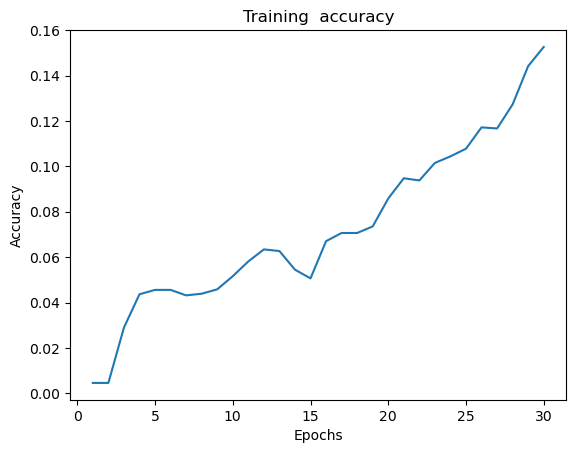

In [84]:
acc_train = np.array(history.history['categorical_accuracy'])
print(epochs)
print(acc_train)
plt.plot(epochs,acc_train)
plt.title('Training  accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Generate text

In [85]:
print (generate_text("united states is a", 20, model, max_sequence_len_train))

1/1 [==============================] - 0s 30ms/step
United States Is A Man In The Man In The Man In The Man In The Man In The Man In The Man In
